<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration8_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화리뷰 감성분석 도전하기

코랩에서의 실습을 위해 필요한 것들은 설치해 줍니다.

In [1]:
! pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 563 kB/s 
     |████████████████████████████████| 453 kB 62.1 MB/s 


In [2]:
! sudo apt-get install curl git
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.19).
git is already the newest version (1:2.17.1-1ubuntu0.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https

In [3]:
import pandas
import konlpy
import gensim

## 1. 데이터 준비와 확인  
미리 준비된 네이버 영화평점 데이터셋을 불러옵니다.

In [4]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/Colab/Datasets/ratings/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab/Datasets/ratings/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성  
다음으로는 텍스트를 가공하여 work_to_index를 구성해 줍시다. 데이터 로더에서는 데이터의 중복 제거, 결측치 제거, 한국어 토크나이저로 토큰화, 불용어 제거 등을 수행한 후에 사전을 구성합니다. 

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

구성된 사전에 0, 1, 2, 3에 해당하는 값도 추가해주고 index_to_word도 구성해 주도록 합시다.

In [6]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

아래의 함수들은 각각 인덱스, 단어로 work_to_index, index_to_word에서 반대 값을 불러오는 함수들 입니다.

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [8]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


성공적으로 토큰화가 진행되었습니다.  
다음으로 pad_sequences를 위해 문장의 길이를 통일하도록 하겠습니다. 여기서 각 요소의 길이가 너무 길어지지 않도록 maxlen을 설정할텐데 maxlen은 평균 + 2*표준편차로 하겠습니다.

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


padding은 앞쪽을 채우는 pre와 뒤쪽을 채우는post가 있습니다.  
RNN은 가장 마지막 입력값이 최종 state값에 큰 영향을 비춘다고 하니 앞쪽을 0으로 채우는 pre를 사용해 주겠습니다.

In [11]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


# 4. 모델 구성 및 validation set 구성  
이제 학습시킬 준비를 해봅시다. 일단 14만6000개의 데이터 중 validation 셋을 50000개로 지정하고 나머지를 학습시키겠습니다.

In [12]:
X_val = X_train[:50000]   
y_val = y_train[:50000]

partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


모델은 3가지로 사용할텐데 1개의 LSTM Layer를 사용하는 RNN 모델과, 1-D CNN을 2개 사용하는 모델, GlobalMaxPooling1D 레이어 하나만 사용하는 모델을 사용하겠습니다.

In [13]:
vocab_size = 10000
word_vector_dim = 16

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(20))
model1.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 20)                2960      
                                                                 
 dense (Dense)               (None, 10000)             210000    
                                                                 
 dense_1 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 382,961
Trainable params: 382,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [15]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5. 학습 진행  
준비된 모델을 통해 학습을 진행해 보겠습니다.

In [16]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/10
188/188 [==============================] - 22s 104ms/step - loss: 0.4398 - accuracy: 0.7855 - val_loss: 0.3583 - val_accuracy: 0.8433
Epoch 2/10
188/188 [==============================] - 20s 106ms/step - loss: 0.3356 - accuracy: 0.8569 - val_loss: 0.3528 - val_accuracy: 0.8475
Epoch 3/10
188/188 [==============================] - 19s 102ms/step - loss: 0.3149 - accuracy: 0.8683 - val_loss: 0.3563 - val_accuracy: 0.8475
Epoch 4/10
188/188 [==============================] - 19s 101ms/step - loss: 0.3004 - accuracy: 0.8748 - val_loss: 0.3677 - val_accuracy: 0.8412
Epoch 5/10
188/188 [==============================] - 19s 101ms/step - loss: 0.2815 - accuracy: 0.8843 - val_loss: 0.3571 - val_accuracy: 0.8468
Epoch 6/10
188/188 [==============================] - 19s 101ms/step - loss: 0.2605 - accuracy: 0.8939 - val_loss: 0.3760 - val_accuracy: 0.8439
Epoch 7/10
188/188 [==============================] - 19s 103ms/step - loss: 0.2414 - accuracy: 0.9018 - val_loss: 0.3998 - val_ac

In [17]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/10
188/188 [==============================] - 6s 27ms/step - loss: 0.5155 - accuracy: 0.7462 - val_loss: 0.3703 - val_accuracy: 0.8354
Epoch 2/10
188/188 [==============================] - 5s 27ms/step - loss: 0.3338 - accuracy: 0.8578 - val_loss: 0.3447 - val_accuracy: 0.8491
Epoch 3/10
188/188 [==============================] - 5s 26ms/step - loss: 0.2987 - accuracy: 0.8754 - val_loss: 0.3428 - val_accuracy: 0.8513
Epoch 4/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2721 - accuracy: 0.8899 - val_loss: 0.3514 - val_accuracy: 0.8500
Epoch 5/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2450 - accuracy: 0.9034 - val_loss: 0.3622 - val_accuracy: 0.8462
Epoch 6/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2177 - accuracy: 0.9166 - val_loss: 0.3834 - val_accuracy: 0.8443
Epoch 7/10
188/188 [==============================] - 5s 27ms/step - loss: 0.1874 - accuracy: 0.9318 - val_loss: 0.4074 - val_accuracy: 0.8421

In [18]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/10
188/188 [==============================] - 3s 11ms/step - loss: 0.6437 - accuracy: 0.7453 - val_loss: 0.5288 - val_accuracy: 0.8060
Epoch 2/10
188/188 [==============================] - 2s 10ms/step - loss: 0.4301 - accuracy: 0.8271 - val_loss: 0.3835 - val_accuracy: 0.8326
Epoch 3/10
188/188 [==============================] - 2s 10ms/step - loss: 0.3473 - accuracy: 0.8529 - val_loss: 0.3607 - val_accuracy: 0.8416
Epoch 4/10
188/188 [==============================] - 2s 10ms/step - loss: 0.3129 - accuracy: 0.8699 - val_loss: 0.3559 - val_accuracy: 0.8443
Epoch 5/10
188/188 [==============================] - 2s 10ms/step - loss: 0.2883 - accuracy: 0.8810 - val_loss: 0.3574 - val_accuracy: 0.8458
Epoch 6/10
188/188 [==============================] - 2s 11ms/step - loss: 0.2686 - accuracy: 0.8907 - val_loss: 0.3626 - val_accuracy: 0.8457
Epoch 7/10
188/188 [==============================] - 2s 10ms/step - loss: 0.2519 - accuracy: 0.8993 - val_loss: 0.3700 - val_accuracy: 0.8452

In [20]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 9s - loss: 0.4645 - accuracy: 0.8324 - 9s/epoch - 6ms/step
[0.4645348787307739, 0.8323941826820374]


In [21]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.5269 - accuracy: 0.8273 - 3s/epoch - 2ms/step
[0.5269402861595154, 0.8273287415504456]


In [22]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.4114 - accuracy: 0.8352 - 2s/epoch - 992us/step
[0.411446750164032, 0.8352422118186951]


각각 0.83, 0.82, 0.83의 정확도를 보였습니다.

## 6. 학습결과분석  
여기서 학습이 진행되는 과정을 그래프로 한번 그려보겠습니다. 

In [27]:
import matplotlib.pyplot as plt

def draw_loss_acc(history):
  history_dict = history.history

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo"는 "파란색 점"입니다
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b는 "파란 실선"입니다
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

  plt.clf()   # 그림을 초기화합니다

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

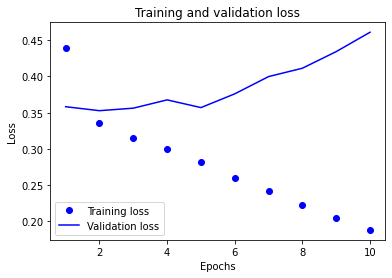

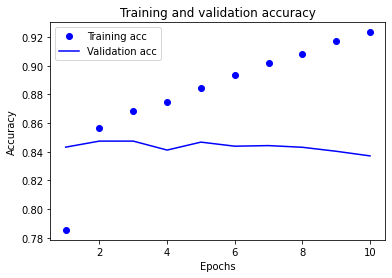

In [28]:
draw_loss_acc(history1)

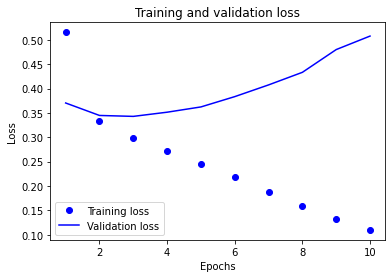

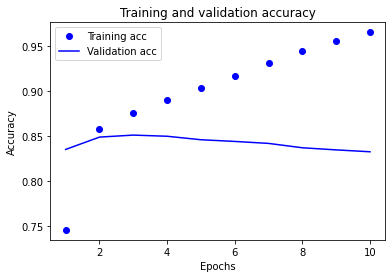

In [29]:
draw_loss_acc(history2)

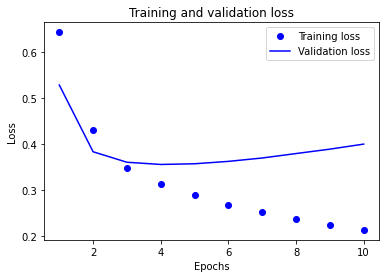

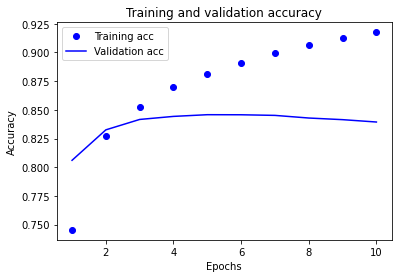

In [30]:
draw_loss_acc(history3)

전체적으로 Train 데이터에 대한 로스와 정확도는 개선되지만 valid set에 대한 값은 5에폭 이후로 줄어드는 것을 볼 수 있습니다.  
## 7. 학습된 임베딩 레이어 분석
다음은 모델이 학습한 임베딩 레이어를 보고 학습이 잘 진행되었는지 확인해 보겠습니다.  
일단 각 모델에 해당하는 임베딩 레이어를 파일로 저장합니다.

In [31]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_1 = '/content/drive/MyDrive/Colab/Datasets/ratings/word2vec/word2vec1.txt'
word2vec_file_path_2 = '/content/drive/MyDrive/Colab/Datasets/ratings/word2vec/word2vec2.txt'
word2vec_file_path_3 = '/content/drive/MyDrive/Colab/Datasets/ratings/word2vec/word2vec3.txt'
# f = open(word2vec_file_path_1, 'w')
# f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
# vectors = model1.get_weights()[0]
# for i in range(4,vocab_size):
#     f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
# f.close()

# f = open(word2vec_file_path_2, 'w')
# f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
# vectors = model2.get_weights()[0]
# for i in range(4,vocab_size):
#     f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
# f.close()

# f = open(word2vec_file_path_3, 'w')
# f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
# vectors = model3.get_weights()[0]
# for i in range(4,vocab_size):
#     f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
# f.close()

다음은 gensim에서 제공하는 패키지를 이용해 임베딩 파라미터를 word vector로 활용해 줍니다.

In [83]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_1, binary=False)
word_vectors_2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_2, binary=False)
word_vectors_3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_3, binary=False)
vector1 = word_vectors_1['끝']
vector2 = word_vectors_2['끝']
vector3 = word_vectors_3['끝']

In [86]:
print(vector1.shape)
print(vector2.shape)
print(vector3.shape)

(16,)
(16,)
(16,)


위에서 얻은 워드벡터로 연기력 에 대한 유사단어를 한번 확인해 보겠습니다.

In [43]:
print(word_vectors_1.similar_by_word("연기력"))
print(word_vectors_2.similar_by_word("연기력"))
print(word_vectors_3.similar_by_word("연기력"))

[('무장', 0.8487152457237244), ('유명', 0.8235666751861572), ('밥상', 0.8076932430267334), ('조카', 0.7886788845062256), ('카지노', 0.7832701206207275), ('벗어난', 0.7676616907119751), ('사납', 0.7264692783355713), ('멈추', 0.7262536287307739), ('이스라엘', 0.7262133359909058), ('노리', 0.7261867523193359)]
[('마리', 0.7628841400146484), ('정녕', 0.7555776834487915), ('차지', 0.7440583109855652), ('ㅋㅋ', 0.6886915564537048), ('까진', 0.682684063911438), ('고정', 0.6670478582382202), ('시킴', 0.6659830808639526), ('기동대', 0.6595077514648438), ('인데', 0.6499807238578796), ('라스트', 0.6453835964202881)]
[('어떡', 0.9718735218048096), ('세기', 0.959601879119873), ('애기', 0.9560952186584473), ('부터', 0.9475662112236023), ('상황', 0.9452989101409912), ('로', 0.9425477981567383), ('자체', 0.9390276074409485), ('마저', 0.9385190010070801), ('거', 0.9365813732147217), ('그래서', 0.9361346960067749)]


모두 다 제각각입니다.

## 8. 한국어 Word2Vec 임베딩 활용한 성능 개선  
이제 주피터 노트북에 제공되어 있는 word2vec_ko 를 이용하여 모델을 학습시켜 보도록 하겠습니다.  

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

pre_word2vec_path = '/content/drive/MyDrive/Colab/Datasets/ratings/word2vec/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(pre_word2vec_path)
vector = word_vectors.wv['끝']

In [50]:
vector.shape

(100,)

불러온 워드벡터에서 연기력에 대한 연관도를 확인해 보면 아래와 같습니다.

In [49]:
print(word_vectors.similar_by_word("연기력"))

[('가창력', 0.8580102920532227), ('존재감', 0.7723670601844788), ('기량', 0.7570468187332153), ('경기력', 0.7401821613311768), ('수비력', 0.7265390157699585), ('입담', 0.7091611623764038), ('배역', 0.7088046073913574), ('연출력', 0.7066310048103333), ('실력', 0.7058062553405762), ('서정성', 0.7030851244926453)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


제가 느끼기에는 전체적으로 연관도가 있는 단어들인 것으로 보입니다.  
이 워드벡터를 이용하여 각 모델을 학습시켜 봅시다.

In [51]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [65]:
from tensorflow.keras.initializers import Constant

model1_pre = tf.keras.Sequential()
model1_pre.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))
model1_pre.add(tf.keras.layers.LSTM(20))
model1_pre.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model1_pre.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1_pre.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 lstm_4 (LSTM)               (None, 20)                9680      
                                                                 
 dense_14 (Dense)            (None, 10000)             210000    
                                                                 
 dense_15 (Dense)            (None, 1)                 10001     
                                                                 
Total params: 1,229,681
Trainable params: 1,229,681
Non-trainable params: 0
_________________________________________________________________


In [57]:
model2_pre = tf.keras.Sequential()
model2_pre.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))
model2_pre.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2_pre.add(tf.keras.layers.MaxPooling1D(5))
model2_pre.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2_pre.add(tf.keras.layers.GlobalMaxPooling1D())
model2_pre.add(tf.keras.layers.Dense(8, activation='relu'))
model2_pre.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2_pre.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 35, 16)            11216     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 16)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                

In [58]:
model3_pre = tf.keras.Sequential()
model3_pre.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))
model3_pre.add(tf.keras.layers.GlobalMaxPooling1D())
model3_pre.add(tf.keras.layers.Dense(8, activation='relu'))
model3_pre.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3_pre.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 global_max_pooling1d_4 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 8)                 808       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [66]:
model1_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history1_pre = model1_pre.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
188/188 [==============================] - 29s 146ms/step - loss: 0.5451 - accuracy: 0.7176 - val_loss: 0.4454 - val_accuracy: 0.7937
Epoch 2/10
188/188 [==============================] - 27s 143ms/step - loss: 0.4085 - accuracy: 0.8151 - val_loss: 0.3857 - val_accuracy: 0.8281
Epoch 3/10
188/188 [==============================] - 28s 149ms/step - loss: 0.3565 - accuracy: 0.8436 - val_loss: 0.3641 - val_accuracy: 0.8401
Epoch 4/10
188/188 [==============================] - 27s 143ms/step - loss: 0.3263 - accuracy: 0.8602 - val_loss: 0.3571 - val_accuracy: 0.8437
Epoch 5/10
188/188 [==============================] - 27s 142ms/step - loss: 0.3040 - accuracy: 0.8704 - val_loss: 0.3562 - val_accuracy: 0.8458
Epoch 6/10
188/188 [==============================] - 27s 143ms/step - loss: 0.2858 - accuracy: 0.8803 - val_loss: 0.3502 - val_accuracy: 0.8471
Epoch 7/10
188/188 [==============================] - 28s 149ms/step - loss: 0.2713 - accuracy: 0.8879 - val_loss: 0.3578 - val_ac

In [59]:
model2_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history2_pre = model2_pre.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
188/188 [==============================] - 19s 95ms/step - loss: 0.5909 - accuracy: 0.6749 - val_loss: 0.5126 - val_accuracy: 0.7527
Epoch 2/10
188/188 [==============================] - 18s 94ms/step - loss: 0.4697 - accuracy: 0.7810 - val_loss: 0.4490 - val_accuracy: 0.7933
Epoch 3/10
188/188 [==============================] - 18s 94ms/step - loss: 0.4084 - accuracy: 0.8166 - val_loss: 0.4151 - val_accuracy: 0.8133
Epoch 4/10
188/188 [==============================] - 18s 94ms/step - loss: 0.3694 - accuracy: 0.8381 - val_loss: 0.3888 - val_accuracy: 0.8256
Epoch 5/10
188/188 [==============================] - 19s 100ms/step - loss: 0.3362 - accuracy: 0.8556 - val_loss: 0.3856 - val_accuracy: 0.8286
Epoch 6/10
188/188 [==============================] - 18s 94ms/step - loss: 0.3133 - accuracy: 0.8676 - val_loss: 0.3736 - val_accuracy: 0.8362
Epoch 7/10
188/188 [==============================] - 18s 94ms/step - loss: 0.2928 - accuracy: 0.8782 - val_loss: 0.3796 - val_accuracy

In [60]:
model3_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history3_pre = model3_pre.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
188/188 [==============================] - 7s 34ms/step - loss: 0.7441 - accuracy: 0.5709 - val_loss: 0.6667 - val_accuracy: 0.6154
Epoch 2/10
188/188 [==============================] - 5s 27ms/step - loss: 0.6357 - accuracy: 0.6419 - val_loss: 0.6157 - val_accuracy: 0.6640
Epoch 3/10
188/188 [==============================] - 5s 27ms/step - loss: 0.5982 - accuracy: 0.6784 - val_loss: 0.5880 - val_accuracy: 0.6888
Epoch 4/10
188/188 [==============================] - 5s 27ms/step - loss: 0.5710 - accuracy: 0.7026 - val_loss: 0.5641 - val_accuracy: 0.7077
Epoch 5/10
188/188 [==============================] - 5s 26ms/step - loss: 0.5489 - accuracy: 0.7208 - val_loss: 0.5451 - val_accuracy: 0.7224
Epoch 6/10
188/188 [==============================] - 5s 27ms/step - loss: 0.5298 - accuracy: 0.7348 - val_loss: 0.5314 - val_accuracy: 0.7304
Epoch 7/10
188/188 [==============================] - 5s 27ms/step - loss: 0.5119 - accuracy: 0.7489 - val_loss: 0.5149 - val_accuracy: 0.7426

In [73]:
results1_pre = model1_pre.evaluate(X_test,  y_test, verbose=2)
print(results1)
print(results1_pre)

1537/1537 - 9s - loss: 0.3797 - accuracy: 0.8438 - 9s/epoch - 6ms/step
[0.4645348787307739, 0.8323941826820374]
[0.37966978549957275, 0.8437862396240234]


In [74]:
results2_pre = model2_pre.evaluate(X_test,  y_test, verbose=2)
print(results2)
print(results2_pre)

1537/1537 - 4s - loss: 0.4009 - accuracy: 0.8335 - 4s/epoch - 2ms/step
[0.5269402861595154, 0.8273287415504456]
[0.4009498059749603, 0.8335333466529846]


In [87]:
results3_pre = model3_pre.evaluate(X_test,  y_test, verbose=2)
print(results3)
print(results3_pre)

1537/1537 - 2s - loss: 0.4882 - accuracy: 0.7631 - 2s/epoch - 1ms/step
[0.411446750164032, 0.8352422118186951]
[0.48815295100212097, 0.7631466388702393]


학습을 진행해본 결과 GlobalMaxPooling1D을 사용한 모델을 제외하고는 정확도가 모두 올랐습니다. GlobalMaxPooling1D 모델은 학습과정에서 정확도가 계속 올라가는 것을 보니 에폭을 조금 늘려주면 더 좋은결과가 나올 수 있을 것 같기도 합니다.  
이제 정확도 85%를 넘어보기 위해 제일 정확도가 높게 나온 첫번째 모델의 하이퍼 파라미터를 조금 조정해 보겠습니다.

In [79]:
from tensorflow.keras.initializers import Constant

model1_pre = tf.keras.Sequential()
model1_pre.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))
model1_pre.add(tf.keras.layers.LSTM(64))
model1_pre.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model1_pre.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1_pre.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dense_18 (Dense)            (None, 10000)             650000    
                                                                 
 dense_19 (Dense)            (None, 1)                 10001     
                                                                 
Total params: 1,702,241
Trainable params: 1,702,241
Non-trainable params: 0
_________________________________________________________________


In [80]:
model1_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7

history1_pre = model1_pre.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/7
188/188 [==============================] - 61s 311ms/step - loss: 0.4996 - accuracy: 0.7526 - val_loss: 0.4200 - val_accuracy: 0.8079
Epoch 2/7
188/188 [==============================] - 57s 301ms/step - loss: 0.3821 - accuracy: 0.8279 - val_loss: 0.3703 - val_accuracy: 0.8335
Epoch 3/7
188/188 [==============================] - 58s 307ms/step - loss: 0.3315 - accuracy: 0.8555 - val_loss: 0.3604 - val_accuracy: 0.8423
Epoch 4/7
188/188 [==============================] - 57s 302ms/step - loss: 0.2985 - accuracy: 0.8727 - val_loss: 0.3504 - val_accuracy: 0.8489
Epoch 5/7
188/188 [==============================] - 58s 308ms/step - loss: 0.2737 - accuracy: 0.8851 - val_loss: 0.3425 - val_accuracy: 0.8517
Epoch 6/7
188/188 [==============================] - 57s 302ms/step - loss: 0.2504 - accuracy: 0.8964 - val_loss: 0.3556 - val_accuracy: 0.8519
Epoch 7/7
188/188 [==============================] - 58s 309ms/step - loss: 0.2306 - accuracy: 0.9055 - val_loss: 0.3642 - val_accuracy:

In [81]:
results1_pre = model1_pre.evaluate(X_test,  y_test, verbose=2)
print(results1)
print(results1_pre)

1537/1537 - 14s - loss: 0.3697 - accuracy: 0.8503 - 14s/epoch - 9ms/step
[0.4645348787307739, 0.8323941826820374]
[0.36970260739326477, 0.8503163456916809]


LSTM의 히든 레이어를 조정하니 85%의 정확도를 얻을 수 있었습니다.

## 9. 회고 
1. 다양한 모델을 조금씩 다르게 사용하려다 보니 코드가 길어져서 살짝 어지러웠다.
2. 한국어도 이런식으로 학습하여 의사를 분석할 수 있다는 것이 놀라웠다. 
3. 지금은 긍정적인지 부정적인지 두가지로만 분류하는 모델이었지만 수많은 사람의 감정을 인공지능으로 학습할 수 있다면 정말 대단한 무언가가 탄생하지 않을까 싶다. 비꼬는 표현까지 구분할 수 있다면.. 엄청 신기할듯